In [1]:
# Adopted from SMRT code: https://github.com/smrt-model/smrt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
sys.path.append("../smrt")
from smrt import make_snowpack, make_model, make_soil, sensor_list, make_ice_column, PSU
from smrt.atmosphere.simple_isotropic_atmosphere import SimpleIsotropicAtmosphere
from smrt.microstructure_model.sticky_hard_spheres import StickyHardSpheres
import smrt
import argparse

In [2]:
class Emissivity:
    def __init__(self, instr_parameters=None, model_parameters=None):
                
        # Instrumental parameters
        if instr_parameters is None:
            self.fq_list = [37e9]
            self.polarizations = ['h', 'v']
            self.theta = 55
        else:
            self.fq_list = instr_parameters['fq_list']
            self.polarizations = instr_parameters['polarizations']
            self.theta = instr_parameters['theta']
            
        self.radiometer = sensor_list.passive(self.fq_list, self.theta)
        n_max_stream = 128  # TB calculation is more accurate if number of streams is increased (currently: default = 32)
        
        # create the EM Model
        self.m = make_model("iba", "dort",
                            rtsolver_options={"n_max_stream": n_max_stream,
                                              'phase_normalization': "forced"})
        
        # Snow and surface parameters
        self.sn_ms_model_list = ['autocorrelation', 'exponential', 'gaussian_random_field',
                            'homogeneous', 'independent_sphere', 'sampled_autocorrelation',
                            'sticky_hard_spheres','test_autocorrelation', 'test_exponential',
                            'test_sticky_hard_spheres', 'teubner_strey', 'unified_autocorrelation',
                            'unified_scaled_exponential', 'unified_sticky_hard_spheres', 'unified_teubner_strey']
        
        if model_parameters is None:
            self.e_equation = 1
            self.substrate = 'land'
            self.roughness_rms = 0.01
            self.stickiness = 0.2
            self.radius = 0.3e-3
            self.sn_ms_model = self.sn_ms_model_list[6]
            self.sn_thickness = [1]
            self.sn_density = [320]
            self.sn_temp = 265
            self.surface_temp =self.sn_temp
        else:
            self.e_equation = model_parameters['e_equation']
            self.substrate = model_parameters['substrate']
            self.roughness_rms = model_parameters['roughness_rms']
            self.stickiness = model_parameters['stickiness']
            self.radius = model_parameters['radius']
            self.sn_ms_model = self.sn_ms_model_list[model_parameters['sn_ms_model']]
            
            if type(model_parameters['sn_thickness']) == list:
                self.sn_thickness = model_parameters['sn_thickness']
            else:
                self.sn_thickness = [model_parameters['sn_thickness']]
                
            if type(model_parameters['sn_density']) == list:
                self.sn_density = model_parameters['sn_density']
            else:
                self.sn_density = [model_parameters['sn_density']]           

            self.sn_temp = model_parameters['sn_temp']
            self.surface_temp = model_parameters['surface_temp']
            
        print(f'Start initializing snowpack with:')
        print(f'Microstructure model: {self.sn_ms_model}')
        print(f'Snow density: {self.sn_density}')
        print(f'Snow temperature: {self.sn_temp}')
        print(f'Sphere radius: {self.radius}')
        print(f'Stickiness: {self.stickiness}')
        self.snowpack = make_snowpack(microstructure_model=self.sn_ms_model,
                                density=self.sn_density,
                                thickness=self.sn_thickness,
                                temperature=self.sn_temp,
                                radius=self.radius,
                                stickiness=self.stickiness)
        print('Done.\n')
        
        print('Adding sustrate...')
        self.add_substrate()
        print('Done.\n')
        
        print('Calculate emissivity...')
        self.calc_e()
        print('Done.\n')
        
    def add_substrate(self, substrate_parameters=None):
        '''
        Add substrate
        '''
        
        if self.substrate == 'land':
            
            if substrate_parameters is None:
                print(f'Substrate: {self.substrate}')
                print(f'Roughness RMS: {self.roughness_rms}')
                self.substrate = make_soil('soil_wegmuller',
                                      permittivity_model=complex(10, 1),
                                      roughness_rms=self.roughness_rms,
                                      temperature=self.surface_temp)
            else:
                

        if self.substrate == 'MYI':
            print(f'Substrate: {self.substrate}')
            # prepare inputs
            l = 9  # 9 ice layers
            thickness = np.array([1.5 / l] * l)  # ice is 1.5m thick
            p_ex = np.array([1.0e-3] * (l))  # correlation length
            temperature = np.linspace(self.surface_temp, 273.15 - 1.8,
                                      l)  # temperature gradient in the ice from T deg K at top to freezing temperature of water at bottom (-1.8 deg C)
            salinity = np.linspace(2., 10.,
                                   l) * PSU  # salinity profile ranging from salinity=2 at the top to salinity=10 at the bottom of the ice

            # create a multi-year sea ice column with assumption of spherical brine inclusions (brine_inclusion_shape="spheres"), and 10% porosity:
            ice_type = 'multiyear'  # first-year or multi-year sea ice
            porosity = 0.08  # ice porosity in fractions, [0..1]

            self.substrate = make_ice_column(ice_type=ice_type, thickness=thickness,
                                        temperature=self.surface_temp,
                                        microstructure_model="exponential",
                                        brine_inclusion_shape="spheres",
                                        # brine_inclusion_shape can be "spheres", "random_needles" or "mix_spheres_needles"
                                        salinity=salinity,
                                        # either 'salinity' or 'brine_volume_fraction' should be given for sea ice; if salinity is given, brine volume fraction is calculated in the model; if none is given, ice is treated as fresh water ice
                                        porosity=porosity,
                                        # either density or 'porosity' should be set for sea ice. If porosity is given, density is calculated in the model. If none is given, ice is treated as having a porosity of 0% (no air inclusions)
                                        corr_length=p_ex,
                                        add_water_substrate="ocean"  # see comment below
                                        )
        
        # 1K atmosphere
        self.Tbdown = 1
        self.atmosphere1K = SimpleIsotropicAtmosphere(tbdown=self.Tbdown,
                                                      tbup=0,
                                                      trans=1)

        # Add snowpack on top of substrate:
        self.medium = self.snowpack + self.substrate
   
    def calc_e(self):
        '''
        Calculate Emissivity
        '''

        # Run model without atmsophere
        sresult_0 = self.m.run(self.radiometer, self.medium)
        # Run model without 1K atmosphere
        self.medium.atmosphere = self.atmosphere1K
        sresult_1 = self.m.run(self.radiometer, self.medium)

        # V-pol
        if self.e_equation == 1:
            print(f'Equation {self.e_equation}')
            self.emissivity_V = 1 - (sresult_1.TbV() - sresult_0.TbV()) / self.Tbdown
        elif self.e_equation == 2:
            print(f'Equation {self.e_equation}')
            self.emissivity_V = (sresult_0.TbV()) / self.surface_temp
        else:
            raise('Please specify correct equation number (1/2)')
        print(f'Ev={self.emissivity_V}')

        # H-pol
        if self.e_equation == 1:
            print(f'Equation {self.e_equation}')
            #reflectivity_H = ( sresult_1.TbH() - sresult_0.TbH() ) / Tbdown
            self.emissivity_H = 1 - (sresult_1.TbH() - sresult_0.TbH()) / self.Tbdown
        elif self.e_equation == 2:
            print(f'Equation {self.e_equation}')
            self.emissivity_H = (sresult_0.TbH()) / self.surface_temp
        else:
            raise('Please specify correct equation number (1/2)')
        print(f'Eh={self.emissivity_H}')
        
        # From old code (incorrect?)
        #reflectivity_H = (sresult_0.TbH() + sresult_1.TbH()) / 2 / T

In [3]:
e = Emissivity()

Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [320]
Snow temperature: 265
Sphere radius: 0.0003
Stickiness: 0.2
Done.

Adding sustrate...
Substrate: land
Roughness RMS: 0.01
Done.

Calculate emissivity...
Equation 1
Ev=0.9094322948010074
Equation 1
Eh=0.8350242135876726
Done.



Snowpack density: 100
Frequency: 7.0
Snow thickness: 0.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9837753772355313
Equation 1
Eh=0.8398418407689405
Done.

Snow thickness: 0.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.98379194660032
Equation 1
Eh=0.8400103993806738
Done.

Snow thickness: 0.21000000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9838084972107026
Equation 1
Eh=0.84017876

Equation 1
Ev=0.9841840431663513
Equation 1
Eh=0.8439995054780809
Done.

Snow thickness: 2.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9842001511756848
Equation 1
Eh=0.8441633955041539
Done.

Snow thickness: 2.71
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9842162410441233
Equation 1
Eh=0.8443271015448772
Done.

Snow thickness: 2.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9842323127945747
E

Equation 1
Ev=0.9757358394065818
Equation 1
Eh=0.8391258185900767
Done.

Snow thickness: 2.21
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9757930976771831
Equation 1
Eh=0.8395227584057068
Done.

Snow thickness: 2.31
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9758502028589078
Equation 1
Eh=0.8399186429167571
Done.

Snow thickness: 2.41
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9759071554258867
E

Equation 1
Ev=0.9700076624488361
Equation 1
Eh=0.8434564471262718
Done.

Snow thickness: 1.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9701940005294318
Equation 1
Eh=0.8445631580633517
Done.

Snow thickness: 1.9100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9703788991588453
Equation 1
Eh=0.8456611892828789
Done.

Snow thickness: 2.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9705

Equation 1
Ev=0.9701782738354154
Equation 1
Eh=0.847485806683693
Done.

Snow thickness: 1.4100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9704394099111369
Equation 1
Eh=0.8491699060436133
Done.

Snow thickness: 1.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.970697388478186
Equation 1
Eh=0.8508328346373446
Done.

Snow thickness: 1.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.970952

Equation 1
Ev=0.9715290246984978
Equation 1
Eh=0.8617738310881293
Done.

Snow thickness: 1.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.971813511226685
Equation 1
Eh=0.8650925571302537
Done.

Snow thickness: 1.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9720904495734999
Equation 1
Eh=0.8683089746045312
Done.

Snow thickness: 1.2100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.97236

Equation 1
Ev=0.9329388082121852
Equation 1
Eh=0.8761002614291158
Done.

Snow thickness: 0.6100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9290742462218873
Equation 1
Eh=0.87921599462004
Done.

Snow thickness: 0.7100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9260606697040714
Equation 1
Eh=0.8815738446672299
Done.

Snow thickness: 0.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation

Equation 1
Ev=0.9820969106696111
Equation 1
Eh=0.8699716936857556
Done.

Snow thickness: 0.21000000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9821346260226846
Equation 1
Eh=0.8702033891781866
Done.

Snow thickness: 0.31000000000000005
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9821722521225524
Equation 1
Eh=0.8704345467860151
Done.

Snow thickness: 0.41000000000000003
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emi

Equation 1
Ev=0.983049596810929
Equation 1
Eh=0.8758247005159205
Done.

Snow thickness: 2.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9830851075186047
Equation 1
Eh=0.8760428571142995
Done.

Snow thickness: 2.91
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9831205364397988
Equation 1
Eh=0.8762605095634797
Done.

Frequency: 11.0
Snow thickness: 0.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.972

Equation 1
Ev=0.9756758432277479
Equation 1
Eh=0.8729257959996914
Done.

Snow thickness: 2.41
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9757960401757941
Equation 1
Eh=0.8734519987131932
Done.

Snow thickness: 2.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9759155761656189
Equation 1
Eh=0.8739753232624423
Done.

Snow thickness: 2.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9760344554563289
E

Equation 1
Ev=0.9729713440613637
Equation 1
Eh=0.8826113347290914
Done.

Snow thickness: 2.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9733377357301833
Equation 1
Eh=0.8839642718940297
Done.

Snow thickness: 2.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.973698320216613
Equation 1
Eh=0.8852955836498779
Done.

Snow thickness: 2.21
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9740531953693221
Eq

Equation 1
Ev=0.9741987698532171
Equation 1
Eh=0.8888252695986409
Done.

Snow thickness: 1.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9747156018619876
Equation 1
Eh=0.8907803487018953
Done.

Snow thickness: 1.7100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9752195041616005
Equation 1
Eh=0.8926856616771204
Done.

Snow thickness: 1.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9757

Equation 1
Ev=0.9780803690666744
Equation 1
Eh=0.9075694213504164
Done.

Snow thickness: 1.2100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.97877453937474
Equation 1
Eh=0.9107257345764026
Done.

Snow thickness: 1.31
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9794278490239776
Equation 1
Eh=0.9136893168332278
Done.

Snow thickness: 1.4100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation

Equation 1
Ev=0.9535869839739064
Equation 1
Eh=0.9113524873114045
Done.

Snow thickness: 0.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9532597673796204
Equation 1
Eh=0.9119272054514909
Done.

Snow thickness: 0.91
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9530525382762391
Equation 1
Eh=0.9122806035249198
Done.

Snow thickness: 1.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9529213175636357
E

Equation 1
Ev=0.9830551816091315
Equation 1
Eh=0.8803689958514269
Done.

Snow thickness: 0.41000000000000003
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9831114094623103
Equation 1
Eh=0.8805985179185996
Done.

Snow thickness: 0.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9831674333137244
Equation 1
Eh=0.8808272169291342
Done.

Snow thickness: 0.6100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equat

Equation 1
Ev=0.984453198953247
Equation 1
Eh=0.8860771860179568
Done.

Frequency: 11.0
Snow thickness: 0.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9735249702214333
Equation 1
Eh=0.8697630416916695
Done.

Snow thickness: 0.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.973735334575963
Equation 1
Eh=0.8703901185440088
Done.

Snow thickness: 0.21000000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equat

Equation 1
Ev=0.9782679327631172
Equation 1
Eh=0.8839357481627133
Done.

Snow thickness: 2.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9784372453034393
Equation 1
Eh=0.8844423895264697
Done.

Snow thickness: 2.71
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9786051258554949
Equation 1
Eh=0.8849447636999912
Done.

Snow thickness: 2.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9787715878154017
E

Equation 1
Ev=0.978546652069042
Equation 1
Eh=0.89487066708827
Done.

Snow thickness: 2.21
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9790114143061146
Equation 1
Eh=0.8960526237112845
Done.

Snow thickness: 2.31
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.979464907380418
Equation 1
Eh=0.897205776813621
Done.

Snow thickness: 2.41
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9799074178421847
Equati

Equation 1
Ev=0.9808417086203463
Equation 1
Eh=0.9014098344816261
Done.

Snow thickness: 1.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9814653587044404
Equation 1
Eh=0.9030004191056662
Done.

Snow thickness: 1.9100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9820652308327453
Equation 1
Eh=0.9045297488349036
Done.

Snow thickness: 2.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9826

Equation 1
Ev=0.98684568590852
Equation 1
Eh=0.9181249335837833
Done.

Snow thickness: 1.4100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9875639750609935
Equation 1
Eh=0.9200889165603314
Done.

Snow thickness: 1.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9882188068796154
Equation 1
Eh=0.9218760970351241
Done.

Snow thickness: 1.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.988815

Equation 1
Ev=0.9767700267914847
Equation 1
Eh=0.9171846095596834
Done.

Snow thickness: 1.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9767741431836043
Equation 1
Eh=0.9172444459293274
Done.

Snow thickness: 1.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9767766095578168
Equation 1
Eh=0.9172762338084794
Done.

Snow thickness: 1.2100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9767

Equation 1
Ev=0.9854264331468698
Equation 1
Eh=0.8767021593562845
Done.

Snow thickness: 0.6100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9854943928924627
Equation 1
Eh=0.8768962803955276
Done.

Snow thickness: 0.7100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9855620152047777
Equation 1
Eh=0.8770894506886009
Done.

Snow thickness: 0.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equati

Equation 1
Ev=0.9760074519372779
Equation 1
Eh=0.8664346397290501
Done.

Snow thickness: 0.21000000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9762758036044943
Equation 1
Eh=0.8670088702619694
Done.

Snow thickness: 0.31000000000000005
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9765404549580694
Equation 1
Eh=0.8675759016627751
Done.

Snow thickness: 0.41000000000000003
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emi

Equation 1
Ev=0.9820150585777583
Equation 1
Eh=0.8793559235224961
Done.

Snow thickness: 2.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9822112782897534
Equation 1
Eh=0.8797790152041216
Done.

Snow thickness: 2.91
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9824052354739479
Equation 1
Eh=0.8801972566284917
Done.

Frequency: 19.0
Snow thickness: 0.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.96

Equation 1
Ev=0.9845303762775188
Equation 1
Eh=0.8892196814107365
Done.

Snow thickness: 2.41
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9850023097627627
Equation 1
Eh=0.8901033618459451
Done.

Snow thickness: 2.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9854587967917041
Equation 1
Eh=0.8909580361676603
Done.

Snow thickness: 2.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9859003624331422
E

Equation 1
Ev=0.9874212395853874
Equation 1
Eh=0.894878897989372
Done.

Snow thickness: 2.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9880036521464604
Equation 1
Eh=0.8959644964113807
Done.

Snow thickness: 2.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9885562521694737
Equation 1
Eh=0.8969941700567574
Done.

Snow thickness: 2.21
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9890806010081405
Eq

Equation 1
Ev=0.9936938815790768
Equation 1
Eh=0.9068841064098194
Done.

Snow thickness: 1.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9941931100053125
Equation 1
Eh=0.9078397460069425
Done.

Snow thickness: 1.7100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9946341150631497
Equation 1
Eh=0.9086826782311164
Done.

Snow thickness: 1.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9950

Equation 1
Ev=0.9903420316938991
Equation 1
Eh=0.9057924849932419
Done.

Snow thickness: 1.2100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.990343476832436
Equation 1
Eh=0.9057958007198863
Done.

Snow thickness: 1.31
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9903441597384699
Equation 1
Eh=0.9057973316108132
Done.

Snow thickness: 1.4100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equatio

Equation 1
Ev=0.9880169860747401
Equation 1
Eh=0.8637226603040631
Done.

Snow thickness: 0.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9880895060246644
Equation 1
Eh=0.863872027137063
Done.

Snow thickness: 0.91
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9881615614378347
Equation 1
Eh=0.864020458144779
Done.

Snow thickness: 1.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9882331568311997
Equ

Equation 1
Ev=0.9791269065075312
Equation 1
Eh=0.8544820331587175
Done.

Snow thickness: 0.41000000000000003
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9794282984805704
Equation 1
Eh=0.8549683730721824
Done.

Snow thickness: 0.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9797248173067032
Equation 1
Eh=0.8554471751457697
Done.

Snow thickness: 0.6100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equat

Equation 1
Ev=0.9856245162248456
Equation 1
Eh=0.8650151961208792
Done.

Frequency: 19.0
Snow thickness: 0.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9702638168005819
Equation 1
Eh=0.8451666384170267
Done.

Snow thickness: 0.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9715301057283909
Equation 1
Eh=0.8469824926674221
Done.

Snow thickness: 0.21000000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equ

Equation 1
Ev=0.9894634489846794
Equation 1
Eh=0.8730308684937143
Done.

Snow thickness: 2.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9898805763098153
Equation 1
Eh=0.873639222423094
Done.

Snow thickness: 2.71
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.99028056851364
Equation 1
Eh=0.8742225514225481
Done.

Snow thickness: 2.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9906641510690974
Equa

Equation 1
Ev=0.992392920319844
Equation 1
Eh=0.8773888905027718
Done.

Snow thickness: 2.21
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9928547039239106
Equation 1
Eh=0.8780579692180481
Done.

Snow thickness: 2.31
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9932869509519833
Equation 1
Eh=0.8786840886542109
Done.

Snow thickness: 2.41
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9936915815765701
Eq

Equation 1
Ev=0.9975375754171978
Equation 1
Eh=0.8848985706845838
Done.

Snow thickness: 1.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9978046091709984
Equation 1
Eh=0.885288700667644
Done.

Snow thickness: 1.9100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9980332164748233
Equation 1
Eh=0.8856223321435834
Done.

Snow thickness: 2.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.99822

Equation 1
Ev=0.9967563375689679
Equation 1
Eh=0.8845593548520014
Done.

Snow thickness: 1.4100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9967563963434714
Equation 1
Eh=0.8845594423710565
Done.

Snow thickness: 1.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9967564200574657
Equation 1
Eh=0.8845594772745073
Done.

Snow thickness: 1.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9967

Equation 1
Ev=0.9899072031178662
Equation 1
Eh=0.8450024924180752
Done.

Snow thickness: 0.91
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9899798315253179
Equation 1
Eh=0.8451133414003493
Done.

Snow thickness: 1.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9900518915696352
Equation 1
Eh=0.8452233419645836
Done.

Snow thickness: 1.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9901233896467261
E

Equation 1
Ev=0.9814380437781551
Equation 1
Eh=0.8364335221264128
Done.

Snow thickness: 0.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9817611544257829
Equation 1
Eh=0.8368470937073198
Done.

Snow thickness: 0.6100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.982077832600794
Equation 1
Eh=0.8372527049793916
Done.

Snow thickness: 0.7100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equatio

Equation 1
Ev=0.9722078522604534
Equation 1
Eh=0.8270746964643365
Done.

Snow thickness: 0.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9736511784449817
Equation 1
Eh=0.8287798076688944
Done.

Snow thickness: 0.21000000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9750011207432863
Equation 1
Eh=0.8303794110902061
Done.

Snow thickness: 0.31000000000000005
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equa

Equation 1
Ev=0.9923797796197391
Equation 1
Eh=0.8511738889484093
Done.

Snow thickness: 2.71
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9927345472577258
Equation 1
Eh=0.8516001722854014
Done.

Snow thickness: 2.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9930718705946902
Equation 1
Eh=0.8520054941674573
Done.

Snow thickness: 2.91
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9933926296384925
E

Equation 1
Ev=0.9949801394212727
Equation 1
Eh=0.8543343040170726
Done.

Snow thickness: 2.31
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9953351540352742
Equation 1
Eh=0.8547582937117681
Done.

Snow thickness: 2.41
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9956630782787101
Equation 1
Eh=0.8551498789984748
Done.

Snow thickness: 2.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9959660048354522
E

Equation 1
Ev=0.9987975541316132
Equation 1
Eh=0.8589285361266832
Done.

Snow thickness: 1.9100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9989399695092516
Equation 1
Eh=0.859098576887078
Done.

Snow thickness: 2.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9990581715201188
Equation 1
Eh=0.8592396260442001
Done.

Snow thickness: 2.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.99915

Equation 1
Ev=0.9989469937739841
Equation 1
Eh=0.8591834193522914
Done.

Snow thickness: 1.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9989469964220916
Equation 1
Eh=0.8591834224995125
Done.

Snow thickness: 1.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9989469973307337
Equation 1
Eh=0.8591834235735973
Done.

Snow thickness: 1.7100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9989

Equation 1
Ev=0.9839093979255153
Equation 1
Eh=0.8413443181501918
Done.

Snow thickness: 1.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9839242238977022
Equation 1
Eh=0.8415103287581189
Done.

Snow thickness: 1.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9839390333556253
Equation 1
Eh=0.8416761519868601
Done.

Snow thickness: 1.2100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Don

Equation 1
Ev=0.9746483773132013
Equation 1
Eh=0.8317809399804332
Done.

Snow thickness: 0.41000000000000003
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9746988400144687
Equation 1
Eh=0.8321921598742961
Done.

Snow thickness: 0.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9747491705337552
Equation 1
Eh=0.8326022723870778
Done.

Snow thickness: 0.6100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Sub

Equation 1
Ev=0.9758237221156492
Equation 1
Eh=0.841350468783844
Done.

Snow thickness: 2.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.975871110133312
Equation 1
Eh=0.8417359110924849
Done.

Snow thickness: 2.91
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9759183743313997
Equation 1
Eh=0.8421203149275129
Done.

Frequency: 19.0
Snow thickness: 0.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Don

Equation 1
Ev=0.9691163761668804
Equation 1
Eh=0.8468674758716475
Done.

Snow thickness: 2.21
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9692269104158413
Equation 1
Eh=0.8478938124830222
Done.

Snow thickness: 2.31
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9693366334178677
Equation 1
Eh=0.848911720167365
Done.

Snow thickness: 2.41
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate e

Equation 1
Ev=0.9678004901048212
Equation 1
Eh=0.8490863389375818
Done.

Snow thickness: 1.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9678826892332495
Equation 1
Eh=0.8506101502802323
Done.

Snow thickness: 1.7100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9679640521028432
Equation 1
Eh=0.8521132251090933
Done.

Snow thickness: 1.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Don

Equation 1
Ev=0.9615337004265427
Equation 1
Eh=0.8550225895229175
Done.

Snow thickness: 1.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9608921815961367
Equation 1
Eh=0.8576089218370555
Done.

Snow thickness: 1.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9602754418373536
Equation 1
Eh=0.8600994208126167
Done.

Snow thickness: 1.2100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Don

Equation 1
Ev=0.8554454404706746
Equation 1
Eh=0.7923011176511636
Done.

Snow thickness: 0.41000000000000003
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.8368935955773509
Equation 1
Eh=0.7833143168541312
Done.

Snow thickness: 0.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.8240255996576593
Equation 1
Eh=0.7764845905306856
Done.

Snow thickness: 0.6100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Sub

Equation 1
Ev=0.7941050785410084
Equation 1
Eh=0.7564087461680629
Done.

Snow thickness: 2.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.794099199677504
Equation 1
Eh=0.7564019054478592
Done.

Snow thickness: 2.91
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.7940948855975307
Equation 1
Eh=0.7563968344050807
Done.

Snowpack density: 200
Frequency: 7.0
Snow thickness: 0.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate

Equation 1
Ev=0.9828025340875683
Equation 1
Eh=0.874483479187603
Done.

Snow thickness: 2.21
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9828370517404323
Equation 1
Eh=0.8747036644919888
Done.

Snow thickness: 2.31
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9828714898863495
Equation 1
Eh=0.8749233386636206
Done.

Snow thickness: 2.41
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate e

Equation 1
Ev=0.9745525222576816
Equation 1
Eh=0.8685172743454359
Done.

Snow thickness: 1.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9746695460581805
Equation 1
Eh=0.8690610297629178
Done.

Snow thickness: 1.7100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.974785922123715
Equation 1
Eh=0.8696017747919598
Done.

Snow thickness: 1.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done

Equation 1
Ev=0.9682702335904878
Equation 1
Eh=0.8673277179253489
Done.

Snow thickness: 1.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9686308444377119
Equation 1
Eh=0.868865440720981
Done.

Snow thickness: 1.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9689856494968581
Equation 1
Eh=0.8703776842551179
Done.

Snow thickness: 1.2100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done

Equation 1
Ev=0.9662318705771327
Equation 1
Eh=0.8605466778870721
Done.

Snow thickness: 0.41000000000000003
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9667457341641352
Equation 1
Eh=0.8630792813347057
Done.

Snow thickness: 0.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9672465046602383
Equation 1
Eh=0.8655435666631774
Done.

Snow thickness: 0.6100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Sub

Equation 1
Ev=0.9755375413940328
Equation 1
Eh=0.9057413348841976
Done.

Snow thickness: 2.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9758135847939116
Equation 1
Eh=0.907056644012755
Done.

Snow thickness: 2.91
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9760825733632146
Equation 1
Eh=0.9083365860163894
Done.

Frequency: 37.0
Snow thickness: 0.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Do

Equation 1
Ev=0.9689933966279227
Equation 1
Eh=0.9170585750278519
Done.

Snow thickness: 2.21
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9690497726260787
Equation 1
Eh=0.9182566889996906
Done.

Snow thickness: 2.31
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.969103290309306
Equation 1
Eh=0.9193714234723132
Done.

Snow thickness: 2.41
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate e

Equation 1
Ev=0.874946834405506
Equation 1
Eh=0.8234972859346499
Done.

Snow thickness: 1.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.8749419703144099
Equation 1
Eh=0.8234920806307002
Done.

Snow thickness: 1.7100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.8749392508196081
Equation 1
Eh=0.8234891063413272
Done.

Snow thickness: 1.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done

Equation 1
Ev=0.9833798453215081
Equation 1
Eh=0.8817260829670204
Done.

Snow thickness: 1.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9834338238994178
Equation 1
Eh=0.88194987099493
Done.

Snow thickness: 1.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9834876083930908
Equation 1
Eh=0.8821728567585296
Done.

Snow thickness: 1.2100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Equation 1
Ev=0.9741304651498695
Equation 1
Eh=0.8716122222072613
Done.

Snow thickness: 0.41000000000000003
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9743289497141632
Equation 1
Eh=0.872218202499937
Done.

Snow thickness: 0.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9745256906904274
Equation 1
Eh=0.8728189791696082
Done.

Snow thickness: 0.6100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Subs

Equation 1
Ev=0.9784495135245379
Equation 1
Eh=0.8848138027929053
Done.

Snow thickness: 2.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9786109070759608
Equation 1
Eh=0.8853073646757537
Done.

Snow thickness: 2.91
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9787709356809842
Equation 1
Eh=0.8857967482603897
Done.

Frequency: 19.0
Snow thickness: 0.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
D

Equation 1
Ev=0.9776336965863948
Equation 1
Eh=0.8940379793042155
Done.

Snow thickness: 2.21
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9780650903287551
Equation 1
Eh=0.8951843138473237
Done.

Snow thickness: 2.31
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9784858949362842
Equation 1
Eh=0.896302165693271
Done.

Snow thickness: 2.41
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate e

Equation 1
Ev=0.9779113516230495
Equation 1
Eh=0.8965388730716484
Done.

Snow thickness: 1.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9785064720997525
Equation 1
Eh=0.898171786224367
Done.

Snow thickness: 1.7100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9790783619907302
Equation 1
Eh=0.8997397146284811
Done.

Snow thickness: 1.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done

Equation 1
Ev=0.97812353448046
Equation 1
Eh=0.903074893488025
Done.

Snow thickness: 1.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9788103971621922
Equation 1
Eh=0.9055019199483922
Done.

Snow thickness: 1.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9794330539713201
Equation 1
Eh=0.9076928331676299
Done.

Snow thickness: 1.2100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.


Equation 1
Ev=0.9378426790835874
Equation 1
Eh=0.8686503520976032
Done.

Snow thickness: 0.41000000000000003
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9357509920898508
Equation 1
Eh=0.8677582666884405
Done.

Snow thickness: 0.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9348078416811347
Equation 1
Eh=0.8672911987909515
Done.

Snow thickness: 0.6100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Sub

Equation 1
Ev=0.93403379798184
Equation 1
Eh=0.8668265706562579
Done.

Snow thickness: 2.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9340337979623428
Equation 1
Eh=0.8668265706332079
Done.

Snow thickness: 2.91
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.934033797952992
Equation 1
Eh=0.8668265706220666
Done.

Snowpack density: 400
Frequency: 7.0
Snow thickness: 0.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate..

Equation 1
Ev=0.9864628190314875
Equation 1
Eh=0.8796860531700759
Done.

Snow thickness: 2.21
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9865251011293594
Equation 1
Eh=0.8798650678672857
Done.

Snow thickness: 2.31
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9865870790704889
Equation 1
Eh=0.8800432107530867
Done.

Snow thickness: 2.41
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate 

Equation 1
Ev=0.9794250497291728
Equation 1
Eh=0.8738333985832014
Done.

Snow thickness: 1.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9796480155183076
Equation 1
Eh=0.8743168461174662
Done.

Snow thickness: 1.7100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9798683599058222
Equation 1
Eh=0.8747946852916755
Done.

Snow thickness: 1.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Don

Equation 1
Ev=0.9757176303273241
Equation 1
Eh=0.8729372746731769
Done.

Snow thickness: 1.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9764540060955937
Equation 1
Eh=0.8743319230050588
Done.

Snow thickness: 1.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9771653113635352
Equation 1
Eh=0.8756794869113662
Done.

Snow thickness: 1.2100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Don

Equation 1
Ev=0.9720939965220055
Equation 1
Eh=0.8665015319907923
Done.

Snow thickness: 0.41000000000000003
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9734110888602459
Equation 1
Eh=0.8690038008634247
Done.

Snow thickness: 0.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.974655981562023
Equation 1
Eh=0.8713708175763486
Done.

Snow thickness: 0.6100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Subs

Equation 1
Ev=0.9901990386621833
Equation 1
Eh=0.9009128128133455
Done.

Snow thickness: 2.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9905604031951043
Equation 1
Eh=0.9015955634129682
Done.

Snow thickness: 2.91
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9909031641209936
Equation 1
Eh=0.9022427625008049
Done.

Frequency: 37.0
Snow thickness: 0.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
D

Equation 1
Ev=0.9924514166389713
Equation 1
Eh=0.9071150843256817
Done.

Snow thickness: 2.21
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9926456011294817
Equation 1
Eh=0.90750026419542
Done.

Snow thickness: 2.31
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9928164759818969
Equation 1
Eh=0.9078384363833152
Done.

Snow thickness: 2.41
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate em

Equation 1
Ev=0.9706694778599285
Equation 1
Eh=0.8826662173830471
Done.

Snow thickness: 1.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9706694734405232
Equation 1
Eh=0.8826662182779614
Done.

Snow thickness: 1.7100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9706694717339133
Equation 1
Eh=0.8826662186322949
Done.

Snow thickness: 1.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Don

Equation 1
Ev=0.9881593504559305
Equation 1
Eh=0.8640182723144392
Done.

Snow thickness: 1.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9882307119733582
Equation 1
Eh=0.8641655423592454
Done.

Snow thickness: 1.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9883016193797403
Equation 1
Eh=0.8643118925580779
Done.

Snow thickness: 1.2100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Don

Equation 1
Ev=0.9791223219699532
Equation 1
Eh=0.8544775383638239
Done.

Snow thickness: 0.41000000000000003
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9794223017672721
Equation 1
Eh=0.8549624856946707
Done.

Snow thickness: 0.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9797174364074976
Equation 1
Eh=0.8554399187088109
Done.

Snow thickness: 0.6100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Sub

Equation 1
Ev=0.9851772566494787
Equation 1
Eh=0.8643081140101003
Done.

Snow thickness: 2.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9853850276376193
Equation 1
Eh=0.8646464584151659
Done.

Snow thickness: 2.91
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9855897490586472
Equation 1
Eh=0.8649798747628097
Done.

Frequency: 19.0
Snow thickness: 0.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
D

Equation 1
Ev=0.9874304926657942
Equation 1
Eh=0.870136956298893
Done.

Snow thickness: 2.21
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9879186323461795
Equation 1
Eh=0.8708505904843094
Done.

Snow thickness: 2.31
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9883865352016983
Equation 1
Eh=0.8715346351602022
Done.

Snow thickness: 2.41
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate e

Equation 1
Ev=0.9885678023885021
Equation 1
Eh=0.871960734602709
Done.

Snow thickness: 1.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.989243252179449
Equation 1
Eh=0.8729438465384192
Done.

Snow thickness: 1.7100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9898748649538902
Equation 1
Eh=0.873863028221507
Done.

Snow thickness: 1.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.


Equation 1
Ev=0.9920318258589873
Equation 1
Eh=0.8771606201103452
Done.

Snow thickness: 1.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.99291246170759
Equation 1
Eh=0.878469065600882
Done.

Snow thickness: 1.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9936637906329224
Equation 1
Eh=0.8795842515895913
Done.

Snow thickness: 1.2100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.


Equation 1
Ev=0.9890267712124228
Equation 1
Eh=0.8753650903631183
Done.

Snow thickness: 0.41000000000000003
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9892970654684632
Equation 1
Eh=0.8759043888585438
Done.

Snow thickness: 0.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9893966229217313
Equation 1
Eh=0.8760988551135256
Done.

Snow thickness: 0.6100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Sub

Equation 1
Ev=0.9894549187895336
Equation 1
Eh=0.8762090234644688
Done.

Snow thickness: 2.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9894549187895336
Equation 1
Eh=0.8762090234644972
Done.

Snow thickness: 2.91
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9894549187895336
Equation 1
Eh=0.8762090234645257
Done.

Snowpack density: 600
Frequency: 7.0
Snow thickness: 0.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrat

Equation 1
Ev=0.9908071535174372
Equation 1
Eh=0.8463780043319105
Done.

Snow thickness: 2.21
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9908727673966382
Equation 1
Eh=0.8464783500655244
Done.

Snow thickness: 2.31
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9909378825587396
Equation 1
Eh=0.8465779422664355
Done.

Snow thickness: 2.41
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate 

Equation 1
Ev=0.9846614950141088
Equation 1
Eh=0.8405716624147317
Done.

Snow thickness: 1.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.984922627950084
Equation 1
Eh=0.8409076941555043
Done.

Snow thickness: 1.7100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9851789562177942
Equation 1
Eh=0.8412376416587222
Done.

Snow thickness: 1.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done

Equation 1
Ev=0.982483248314395
Equation 1
Eh=0.8393044710849153
Done.

Snow thickness: 1.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9833345169965355
Equation 1
Eh=0.840323841386919
Done.

Snow thickness: 1.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9841413195531459
Equation 1
Eh=0.8412905234242487
Done.

Snow thickness: 1.2100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Equation 1
Ev=0.9782377862621843
Equation 1
Eh=0.8343835959155115
Done.

Snow thickness: 0.41000000000000003
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9799218201256963
Equation 1
Eh=0.836382238108655
Done.

Snow thickness: 0.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9814623496254171
Equation 1
Eh=0.838213471064762
Done.

Snow thickness: 0.6100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Subst

Equation 1
Ev=0.9963838394003233
Equation 1
Eh=0.8560237450706722
Done.

Snow thickness: 2.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9966210743630768
Equation 1
Eh=0.8563069166416994
Done.

Snow thickness: 2.91
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.996840251544711
Equation 1
Eh=0.8565684849498609
Done.

Frequency: 37.0
Snow thickness: 0.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Do

Equation 1
Ev=0.9988156083753665
Equation 1
Eh=0.8589841132896083
Done.

Snow thickness: 2.21
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.998894971875643
Equation 1
Eh=0.8590787329223133
Done.

Snow thickness: 2.31
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.998960801664623
Equation 1
Eh=0.8591571679154413
Done.

Snow thickness: 2.41
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate em

Equation 1
Ev=0.9969158223512977
Equation 1
Eh=0.8569603265321462
Done.

Snow thickness: 1.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9969158228880133
Equation 1
Eh=0.8569603271666608
Done.

Snow thickness: 1.7100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9969158230677522
Equation 1
Eh=0.8569603273777489
Done.

Snow thickness: 1.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.00015000000000000001
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Don

Equation 1
Ev=0.9838813027935203
Equation 1
Eh=0.8413292125162855
Done.

Snow thickness: 1.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9838930602908817
Equation 1
Eh=0.8414935612371153
Done.

Snow thickness: 1.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9839048049958592
Equation 1
Eh=0.8416577222122044
Done.

Snow thickness: 1.2100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Don

Equation 1
Ev=0.974589867142754
Equation 1
Eh=0.8317494125383291
Done.

Snow thickness: 0.41000000000000003
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9746215636267834
Equation 1
Eh=0.8321504409527449
Done.

Snow thickness: 0.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.974653180455789
Equation 1
Eh=0.8325503522970621
Done.

Snow thickness: 0.6100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Subst

Equation 1
Ev=0.975329082903329
Equation 1
Eh=0.841072281617528
Done.

Snow thickness: 2.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9753589321508684
Equation 1
Eh=0.8414473761941963
Done.

Snow thickness: 2.91
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9753887071008762
Equation 1
Eh=0.8418214282270355
Done.

Frequency: 19.0
Snow thickness: 0.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Don

Equation 1
Ev=0.9658795943790324
Equation 1
Eh=0.8448731898730557
Done.

Snow thickness: 2.21
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9658498830265216
Equation 1
Eh=0.8458032468212764
Done.

Snow thickness: 2.31
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9658205529850079
Equation 1
Eh=0.8467248816241693
Done.

Snow thickness: 2.41
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate 

Equation 1
Ev=0.9620145879048323
Equation 1
Eh=0.8453969665061152
Done.

Snow thickness: 1.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9617498296197198
Equation 1
Eh=0.8466687054961142
Done.

Snow thickness: 1.7100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9614890415604123
Equation 1
Eh=0.8479199653787646
Done.

Snow thickness: 1.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Don

Equation 1
Ev=0.9414385071605693
Equation 1
Eh=0.8405179528288329
Done.

Snow thickness: 1.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9390018045708359
Equation 1
Eh=0.8415979586044386
Done.

Snow thickness: 1.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9366716441798246
Equation 1
Eh=0.8426141968504339
Done.

Snow thickness: 1.2100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Don

Equation 1
Ev=0.7316137460765617
Equation 1
Eh=0.684998023965278
Done.

Snow thickness: 0.41000000000000003
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.7069031075379826
Equation 1
Eh=0.6658170825779166
Done.

Snow thickness: 0.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.6922088224317804
Equation 1
Eh=0.6535727390592001
Done.

Snow thickness: 0.6100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Subs

Equation 1
Ev=0.6690215750677169
Equation 1
Eh=0.6316989272767728
Done.

Snow thickness: 2.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.6690211085988551
Equation 1
Eh=0.6316983863290204
Done.

Snow thickness: 2.91
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [100]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.6690208059201552
Equation 1
Eh=0.631698035109082
Done.

Snowpack density: 200
Frequency: 7.0
Snow thickness: 0.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate

Equation 1
Ev=0.9827395751335075
Equation 1
Eh=0.87444119565302
Done.

Snow thickness: 2.21
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.982771187924584
Equation 1
Eh=0.8746593817093355
Done.

Snow thickness: 2.31
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9828027279975231
Equation 1
Eh=0.8748770568915063
Done.

Snow thickness: 2.41
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emi

Equation 1
Ev=0.9742836722109018
Equation 1
Eh=0.8683336200304552
Done.

Snow thickness: 1.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9743837708167007
Equation 1
Eh=0.8688653292444712
Done.

Snow thickness: 1.7100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9744833186337587
Equation 1
Eh=0.8693940355276482
Done.

Snow thickness: 1.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Don

Equation 1
Ev=0.9668996642236607
Equation 1
Eh=0.8663559043828286
Done.

Snow thickness: 1.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9671213242676231
Equation 1
Eh=0.8677864140578606
Done.

Snow thickness: 1.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.96733935610456
Equation 1
Eh=0.869191538364106
Done.

Snow thickness: 1.2100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.


Equation 1
Ev=0.9650157851145025
Equation 1
Eh=0.8597103638180101
Done.

Snow thickness: 0.41000000000000003
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9651536115854071
Equation 1
Eh=0.8619658457177479
Done.

Snow thickness: 0.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9652868497227587
Equation 1
Eh=0.8641516427455826
Done.

Snow thickness: 0.6100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Sub

Equation 1
Ev=0.9674473939184622
Equation 1
Eh=0.8985494157802805
Done.

Snow thickness: 2.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9675195247431247
Equation 1
Eh=0.899628997305939
Done.

Snow thickness: 2.91
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9675898854003435
Equation 1
Eh=0.9006761601950473
Done.

Frequency: 37.0
Snow thickness: 0.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [200]
Snow temperature: 265
Sphere radius: 0.00020000000000000004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Do

Equation 1
Ev=0.8374249263780484
Equation 1
Eh=0.763740858220558
Done.

Snow thickness: 2.31
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.8371677040247505
Equation 1
Eh=0.7634902777538457
Done.

Snow thickness: 2.41
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.8369594637315458
Equation 1
Eh=0.7632859098817448
Done.

Snow thickness: 2.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.8367908195759242
Eq

Equation 1
Ev=0.6215320531002249
Equation 1
Eh=0.56051336243425
Done.

Snow thickness: 1.9100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.6215320531002533
Equation 1
Eh=0.56051336243425
Done.

Snow thickness: 2.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.6215320531001964
Equation 1
Eh=0.5605133624341363
Done.

Snow thickness: 2.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [300]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.62153205

Equation 1
Ev=0.9858157579291174
Equation 1
Eh=0.8782214278484446
Done.

Snow thickness: 1.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9858663982436155
Equation 1
Eh=0.8783937544492346
Done.

Snow thickness: 1.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.985916789386124
Equation 1
Eh=0.8785652174633753
Done.

Snow thickness: 1.7100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.98596

Equation 1
Ev=0.9774169651142302
Equation 1
Eh=0.8705372344871591
Done.

Snow thickness: 1.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.97757509055117
Equation 1
Eh=0.8709750998770289
Done.

Snow thickness: 1.2100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9777313069972706
Equation 1
Eh=0.8714075335692826
Done.

Snow thickness: 1.31
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.977885

Equation 1
Ev=0.9690065821213238
Equation 1
Eh=0.8643355568142681
Done.

Snow thickness: 0.7100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9691937796466732
Equation 1
Eh=0.8652552153026534
Done.

Snow thickness: 0.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9693731156202716
Equation 1
Eh=0.8661353206042577
Done.

Snow thickness: 0.91
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9695

Equation 1
Ev=0.9666641461259928
Equation 1
Eh=0.8600626926769053
Done.

Snow thickness: 0.31000000000000005
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9662850818929769
Equation 1
Eh=0.860982094230593
Done.

Snow thickness: 0.41000000000000003
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9659200901558336
Equation 1
Eh=0.861814195246609
Done.

Snow thickness: 0.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equati

Equation 1
Ev=0.9613467307057135
Equation 1
Eh=0.8695454621480394
Done.

Snow thickness: 2.91
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9612717015358783
Equation 1
Eh=0.8696353054627082
Done.

Frequency: 37.0
Snow thickness: 0.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9689263856067214
Equation 1
Eh=0.8602113469806056
Done.

Snow thickness: 0.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.96

Equation 1
Ev=0.9187060377234957
Equation 1
Eh=0.8252985463770983
Done.

Snow thickness: 2.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9186460745440854
Equation 1
Eh=0.8252436788466468
Done.

Snow thickness: 2.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9185979010428014
Equation 1
Eh=0.8251992770832715
Done.

Snow thickness: 2.71
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9185591968573306
E

Equation 1
Ev=0.7541050011904247
Equation 1
Eh=0.6653615259144203
Done.

Snow thickness: 2.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.7541050011904815
Equation 1
Eh=0.6653615259144203
Done.

Snow thickness: 2.21
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.7541050011904247
Equation 1
Eh=0.6653615259144487
Done.

Snow thickness: 2.31
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [400]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.7541050011904247
E

Equation 1
Ev=0.9885519963967795
Equation 1
Eh=0.8649333027697139
Done.

Snow thickness: 1.7100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9886145510537858
Equation 1
Eh=0.8650685483579252
Done.

Snow thickness: 1.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9886767136362664
Equation 1
Eh=0.8652029493132716
Done.

Snow thickness: 1.9100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equati

Equation 1
Ev=0.981236857624026
Equation 1
Eh=0.8581665989813132
Done.

Snow thickness: 1.31
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9814661059522791
Equation 1
Eh=0.8585577103981166
Done.

Snow thickness: 1.4100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9816918610226821
Equation 1
Eh=0.8589429038346168
Done.

Snow thickness: 1.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.98191

Equation 1
Ev=0.9765064866820694
Equation 1
Eh=0.8551911102979659
Done.

Snow thickness: 0.91
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9771381303564795
Equation 1
Eh=0.8562015571351083
Done.

Snow thickness: 1.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9777412103128995
Equation 1
Eh=0.8571658213938917
Done.

Snow thickness: 1.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9783170857378423
E

Equation 1
Ev=0.9741108420052456
Equation 1
Eh=0.8522877323605371
Done.

Snow thickness: 0.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9749440905542883
Equation 1
Eh=0.8537407465281888
Done.

Snow thickness: 0.6100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9757163967645397
Equation 1
Eh=0.8550844916674123
Done.

Snow thickness: 0.7100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equati

Equation 1
Ev=0.9720971100947509
Equation 1
Eh=0.8477819305082335
Done.

Snow thickness: 0.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9714408014622222
Equation 1
Eh=0.8489542663205043
Done.

Snow thickness: 0.21000000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9708411959074965
Equation 1
Eh=0.8497885416543909
Done.

Snow thickness: 0.31000000000000005
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equa

Equation 1
Ev=0.967890133581534
Equation 1
Eh=0.8522446843936962
Done.

Snow thickness: 2.71
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9678861066077502
Equation 1
Eh=0.8522448841863763
Done.

Snow thickness: 2.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9678828460628779
Equation 1
Eh=0.8522449741592197
Done.

Snow thickness: 2.91
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9678802065861873
Eq

Equation 1
Ev=0.8695244345352933
Equation 1
Eh=0.752515402951559
Done.

Snow thickness: 2.31
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.8695244345352648
Equation 1
Eh=0.7525154029515306
Done.

Snow thickness: 2.41
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.8695244345352648
Equation 1
Eh=0.752515402951559
Done.

Snow thickness: 2.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [500]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.8695244345352364
Equ

Equation 1
Ev=0.9905726113805713
Equation 1
Eh=0.8460370926505334
Done.

Snow thickness: 1.9100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9906379833078063
Equation 1
Eh=0.8461379268642872
Done.

Snow thickness: 2.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9907028563179665
Equation 1
Eh=0.8462380007306365
Done.

Snow thickness: 2.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9907

Equation 1
Ev=0.98424437730921
Equation 1
Eh=0.8400753874105931
Done.

Snow thickness: 1.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9845012641229687
Equation 1
Eh=0.8404081447919509
Done.

Snow thickness: 1.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9847533973958775
Equation 1
Eh=0.8407348358555566
Done.

Snow thickness: 1.7100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.985000

Equation 1
Ev=0.9825184363531321
Equation 1
Eh=0.839480793238863
Done.

Snow thickness: 1.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9832655602069167
Equation 1
Eh=0.8403836634039976
Done.

Snow thickness: 1.2100000000000002
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9839734040313601
Equation 1
Eh=0.8412393246454997
Done.

Snow thickness: 1.31
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.98464

Equation 1
Ev=0.9816064420036241
Equation 1
Eh=0.8385817262690409
Done.

Snow thickness: 0.7100000000000001
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9827495420538526
Equation 1
Eh=0.8399620242438743
Done.

Snow thickness: 0.81
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9837976737010194
Equation 1
Eh=0.8412280070508302
Done.

Snow thickness: 0.91
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9847

Equation 1
Ev=0.9799509690045625
Equation 1
Eh=0.8368164250433949
Done.

Snow thickness: 0.31000000000000005
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9819443930599618
Equation 1
Eh=0.8393261759043753
Done.

Snow thickness: 0.41000000000000003
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.983556795494394
Equation 1
Eh=0.8413528578739999
Done.

Snow thickness: 0.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equat

Equation 1
Ev=0.9904592457118611
Equation 1
Eh=0.849940431573458
Done.

Snow thickness: 2.91
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9904681411525189
Equation 1
Eh=0.8499511209786021
Done.

Frequency: 89.0
Snow thickness: 0.01
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.977365091799129
Equation 1
Eh=0.8333924499927718
Done.

Snow thickness: 0.11
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9554

Equation 1
Ev=0.9503531084501731
Equation 1
Eh=0.8082686078599579
Done.

Snow thickness: 2.51
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9503531084502015
Equation 1
Eh=0.8082686078599579
Done.

Snow thickness: 2.61
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9503531084502299
Equation 1
Eh=0.8082686078599579
Done.

Snow thickness: 2.71
Start initializing snowpack with:
Microstructure model: sticky_hard_spheres
Snow density: [600]
Snow temperature: 265
Sphere radius: 0.0004
Stickiness: 0.3
Done.

Adding sustrate...
Substrate: MYI
Done.

Calculate emissivity...
Equation 1
Ev=0.9503531084502299
E

<Figure size 432x288 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

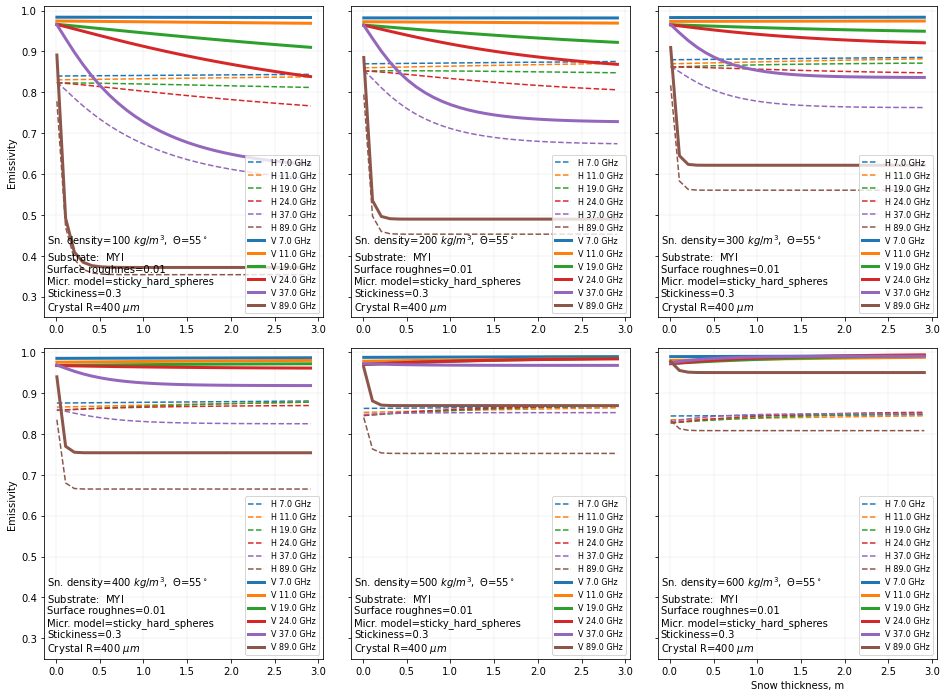

In [5]:
##############################
# Calculate emissivity
##############################

sn_ms_model_list = ['autocorrelation', 'exponential', 'gaussian_random_field',
                            'homogeneous', 'independent_sphere', 'sampled_autocorrelation',
                            'sticky_hard_spheres','test_autocorrelation', 'test_exponential',
                            'test_sticky_hard_spheres', 'teubner_strey', 'unified_autocorrelation',
                            'unified_scaled_exponential', 'unified_sticky_hard_spheres', 'unified_teubner_strey']

densities_list = list(range(100, 700, 100))
fq_list = [7e9, 11e9, 19e9, 24e9, 37e9, 89e9]
theta = 55
polarizations = ['h','v']
sn_th_max = 3.
sn_th_min = 0.01
sn_th_step = 0.1
substrate = 'MYI'
roughness_rms = 0.01
sn_ms_model = 6
stickiness=0.2
radius=0.3e-3
radius_um = int(radius*10**6)

out_path = '/home/denis/git/smrt_experiments/sea_ice/myi'

for stickiness in [0.3]:
    for radius in np.arange(0.1e-3, 0.45e-3, 0.05e-3):
        radius_um = int(radius*10**6)
        d_res = {}

        for sn_density in densities_list:
            d_res[sn_density]= {}
            for pol in polarizations:
                d_res[sn_density][pol]= {}
                d_res[sn_density][pol]= {}

        ll_e1_h, ll_e1_v = [], []

        for sn_density in densities_list:
            print(f'Snowpack density: {sn_density}')
            for idx, fq in enumerate(fq_list):
                print(f'Frequency: {fq/1e9}')
                for s_th in np.arange(sn_th_min, sn_th_max, sn_th_step):
                    print(f'Snow thickness: {s_th}')

                    # Snow and substrate parameters
                    model_parameters = {}
                    
                    model_parameters['snow'] = {}
                    model_parameters['land'] = {}
                    model_parameters['ice'] = {}
                    
                    # Snow
                    model_parameters['snow']['sn_thickness'] = s_th
                    model_parameters['snow']['sn_density'] = sn_density
                    
                    model_parameters['e_equation'] = 1
                    model_parameters['substrate'] = substrate
                    model_parameters['roughness_rms'] = roughness_rms
                    model_parameters['stickiness'] = stickiness
                    model_parameters['radius'] = radius
                    model_parameters['sn_ms_model'] = sn_ms_model
                    model_parameters['sn_temp'] = 265
                    model_parameters['surface_temp'] =265

                    # Instrumental parameters
                    instr_parameters = {}
                    instr_parameters['fq_list'] = fq
                    instr_parameters['polarizations'] = polarizations
                    instr_parameters['theta'] = theta

                    e = Emissivity(model_parameters=model_parameters,
                                   instr_parameters=instr_parameters)    

                    ll_e1_h.append(e.emissivity_H)
                    ll_e1_v.append(e.emissivity_V)

                fq_str = fq / 1e9
                d_res[sn_density]['h'][fq_str] = {}
                d_res[sn_density]['v'][fq_str] = {}
                d_res[sn_density]['h'][fq_str]['e1'] = ll_e1_h
                d_res[sn_density]['v'][fq_str]['e1'] = ll_e1_v
                ll_e1_h, ll_e1_v = [], []

        ########################
        # Plot results
        ########################

        ncols = 3
        nrows = int(np.ceil(len(d_res.keys()) / ncols))

        if substrate == 'land':
            substrate_title = substrate + ' (Wegmuller)'
        else:
            substrate_title = substrate

        plt.clf()
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 12))

        r_ch = 0
        c_ch = 0
        colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]

        for i, density in enumerate(d_res.keys()):
            if r_ch >= ncols:
                r_ch = 0
                c_ch += 1
            pol = 'h'
            for i_color, ikey in enumerate(d_res[density][pol]):
                ax[c_ch, r_ch].plot(np.arange(sn_th_min, sn_th_max, sn_th_step), d_res[density][pol][ikey]['e1'],
                                    label=f'{pol.upper()} {ikey} GHz',
                                    linestyle='dashed', c=colors[i_color])
            text = f'Sn. density={density}$\ kg/m^3,\ \Theta$={theta}$^\circ$' \
                f'\nSubstrate:$\ $ {substrate_title}' \
                f'\nSurface roughnes={roughness_rms}' \
                f'\nMicr. model={sn_ms_model_list[sn_ms_model]}' \
                f'\nStickiness={stickiness}' \
                f'\nCrystal R={radius_um}$\ \mu m$'
            ax[c_ch, r_ch].text(.01, .01, text, ha='left', va='bottom',
                                transform=ax[c_ch, r_ch].transAxes,
                                fontsize='medium')
            pol = 'v'
            for i_color, ikey in enumerate(d_res[density][pol]):
                ax[c_ch, r_ch].plot(np.arange(sn_th_min, sn_th_max, sn_th_step), d_res[density][pol][ikey]['e1'],
                                    label=f'{pol.upper()} {ikey} GHz',
                                    linewidth=3, c=colors[i_color])
            ax[c_ch, r_ch].legend(loc='lower right', prop={'size': 8})
            ax[c_ch, r_ch].grid(linewidth=0.15)
            ax[c_ch, r_ch].set_ylim([0.25, 1.01])
            if r_ch > 0:
                ax[c_ch, r_ch].axes.yaxis.set_ticklabels([])
            if r_ch == 0:
                ax[c_ch, r_ch].set_ylabel('Emissivity')
            r_ch += 1

        plt.xlabel('Snow thickness, m')
        plt.subplots_adjust(hspace=0.1)
        plt.subplots_adjust(wspace=0.1)
        fig.patch.set_facecolor('white')
        plt.savefig(f'{out_path}/E_{substrate}_r{radius_um}_s{stickiness}_{sn_ms_model}.png', bbox_inches='tight', dpi=300)